<a href="https://colab.research.google.com/github/enakai00/rl_book_solutions/blob/master/Chapter08/Exercise_8_1_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 8.1 : Solution

In [0]:
import numpy as np
from numpy import random
from pandas import DataFrame

In [3]:
maze_img = '''
###########
#       # #
#  #    # #
#  #    # #
#  #      #
#     #   #
#         #
###########
'''
def get_track(track_img):
  x_max = max(map(len, track_img.split('\n')))
  track = []
  for line in track_img.split('\n'):
    if line == '':
      continue 
    line += ' ' * x_max
    track.append(list(line)[:x_max])

  return np.array(track)

array([['#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#', ' ', '#'],
       ['#', ' ', ' ', '#', ' ', ' ', ' ', ' ', '#', ' ', '#'],
       ['#', ' ', ' ', '#', ' ', ' ', ' ', ' ', '#', ' ', '#'],
       ['#', ' ', ' ', '#', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', '#', ' ', ' ', ' ', '#'],
       ['#', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', '#'],
       ['#', '#', '#', '#', '#', '#', '#', '#', '#', '#', '#']],
      dtype='<U1')

In [0]:
class Agent:
  def __init__(self, x=1, y=3):
    self.path = []
    self.actions = [(0, 1), (1, 0), (0, -1), (-1, 0)]
    self.q = {}
    self.model = {}
    self.restart(x, y)
    self.maze = get_track(maze_img)

  def restart(self, x=1, y=3):
    self.x, self.y = x, y
    self.path = []
    #self.model = {}

  def get_state(self):
    return self.x, self.y

  def show_path(self):
    result = self.maze.copy()
    for c, (x, y, a) in enumerate(self.path):
      result[y][x] = str(c)[-1]
    result[1][9] = 'G'
    return result     

  def move(self, action):
    self.path.append((self.x, self.y, action))
    sa = "{:02},{:02}:{:02}".format(self.x, self.y, action)
    vx, vy = self.actions[action]
    if self.maze[self.y+vy][self.x+vx] == '#':
      vx, vy = 0, 0
    self.x += vx
    self.y += vy
    if (self.x, self.y) == (9, 1): # Finish
      self.model[sa] = (1, self.x, self.y)
      return True
    self.model[sa] = (0, self.x, self.y)
    return False

In [0]:
q_vals = [2,0,2,1]
q_max = np.max(q_vals)
candidates = []
for i, q in enumerate(q_vals):
  if q == q_max:
    candidates.append(i)
return random.choice(candidates)

In [0]:
def get_action(agent, epsilon):
  if random.random() < epsilon:
    a = random.randint(0, 4)
  else:
    a = optimal_action(agent)
  return a

def optimal_action(agent):
  x, y = agent.get_state()
  q_vals = []
  for a in range(4):
    sa = "{:02},{:02}:{:02}".format(x, y, a)
    if sa not in agent.q.keys():
      agent.q[sa] = 0
    q_vals.append(agent.q[sa])
  q_max = np.max(q_vals)
  candidates = []
  for i, q in enumerate(q_vals):
    if q == q_max:
      candidates.append(i)
  return random.choice(candidates)

def update_q(agent, states, drain=False):
  alpha = 0.1
  gamma = 0.95
  sa1 = states[0]
  if sa1 not in agent.q.keys():
    agent.q[sa1] = 0

  if drain: # Finished
    agent.q[sa1] += alpha * (1 + gamma * 0 - agent.q[sa1])
    states.pop(0)
    if len(states) == 0:
      return
    update_q(agent, states, drain=True)
  else:
    x, y = agent.get_state()
    a = optimal_action(agent)
    sa2 = "{:02},{:02}:{:02}".format(x, y, a)
    if sa2 not in agent.q.keys():
      agent.q[sa2] = 0
    agent.q[sa1] += alpha * (0 + gamma * agent.q[sa2] - agent.q[sa1])

def trial(agent, epsilon=0.1, steps=5, dyna_q=False, planning_steps=5):
  agent.restart()
  states = []
  x, y = agent.get_state()
  
  while True:
    x, y = agent.get_state()
    a = get_action(agent, epsilon)
    sa = "{:02},{:02}:{:02}".format(x, y, a)
    states.append(sa)
    finished = agent.move(a)

    if finished:
      update_q(agent, states, drain=True)
      break
    if len(states) >= steps:
      update_q(agent, states, drain=False)
      states.pop(0)

    if dyna_q:
      for _ in range(planning_steps):
        alpha = 0.1
        gamma = 0.95
        sa1 = np.random.choice(list(agent.model.keys()))
        r, x, y = agent.model[sa1]
        _x, _y = agent.x, agent.y
        agent.x, agent.y = x, y
        a = optimal_action(agent)
        agent.x, agent.y = _x, _y
        sa2 = "{:02},{:02}:{:02}".format(x, y, a)
        if sa1 not in agent.q.keys():
          agent.q[sa1] = 0
        if sa2 not in agent.q.keys():
          agent.q[sa2] = 0
        agent.q[sa1] += alpha * (r + gamma * agent.q[sa2] - agent.q[sa1])

## Comparing different planning steps for Dyna-Q.

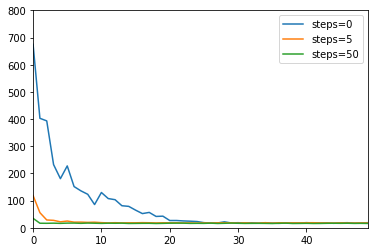

In [135]:
df = DataFrame()

results = np.zeros(51)
for _ in range(20):
  agent = Agent()
  result = []
  for _ in range(51):
    trial(agent, dyna_q=False, steps=1)
    result.append(len(agent.path))
  results += np.array(result)
df['steps=0'] = np.array(results[1:]) / 20

for steps in [5, 50]:
  results = np.zeros(51)
  for _ in range(20):
    agent = Agent()
    result = []
    for _ in range(51):
      trial(agent, dyna_q=True, planning_steps=steps)
      result.append(len(agent.path))
    results += np.array(result)
  df['steps={}'.format(steps)] = np.array(results[1:]) / 20

df.plot(ylim=(0,800))

## Show the learned path.

In [136]:
trial(agent, epsilon=0, steps=1)
for line in agent.show_path():
  print (''.join(line))

###########
#       #G#
#  #    #3#
#0 #    #2#
#12#678901#
# 345 #   #
#         #
###########


## Comparing the different steps for TD(n).

TD(5) achieves the best result, but it's still worse than Dyna-Q.

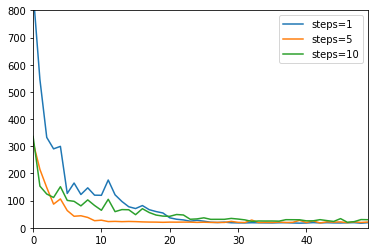

In [139]:
df = DataFrame()

for steps in [1, 5, 10]:
  results = np.zeros(51)
  for _ in range(20):
    agent = Agent()
    result = []
    for _ in range(51):
      trial(agent, dyna_q=False, steps=steps)
      result.append(len(agent.path))
    results += np.array(result)
  df['steps={}'.format(steps)] = np.array(results[1:]) / 20

df.plot(ylim=(0,800))